# benchmarking on omnipath


In [1]:
from bengrn import BenGRN
import scanpy as sc

from anndata.utils import make_index_unique
from grnndata import utils as grnutils

import pandas as pd

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

In [2]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
    adata.var['ensembl_id'] = adata.var.index
    adata.obs['n_counts'] = adata.X.sum(1)
    # Create the geneformer folder if it doesn't exist
    geneformer_folder = "/tmp/geneformer"
    if not os.path.exists(geneformer_folder):
        os.makedirs(geneformer_folder)
    adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

In [3]:
genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']
NUM_GENES = 5000
MAXCELLS = 1024

In [4]:
CELLTYPES = [
'pigmented ciliary epithelial cell',
'fibroblast',
'Schwann cell',
'non-pigmented ciliary epithelial cell',
'ciliary muscle cell',
'lymphocyte',
'melanocyte',
'macrophage',
'blood vessel endothelial cell',
'pericyte'
]

In [5]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad')
#adata = sc.read_h5ad('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint/.lamindb/Gz5G2ETTEuuRDgwm7brA.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
#adata = adata[:, adata.var.index.isin(genes)]
adata

AnnData object with n_obs × n_vars = 34132 × 70263
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered'

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


base enrichment


Top central genes: []


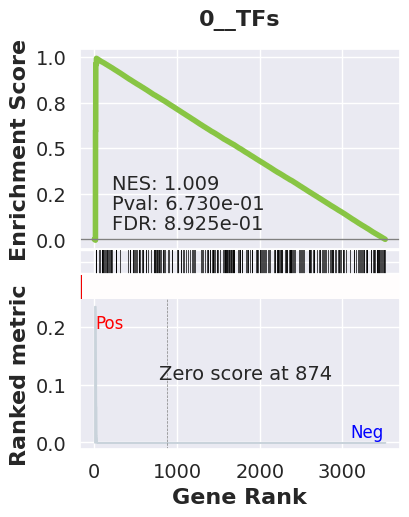

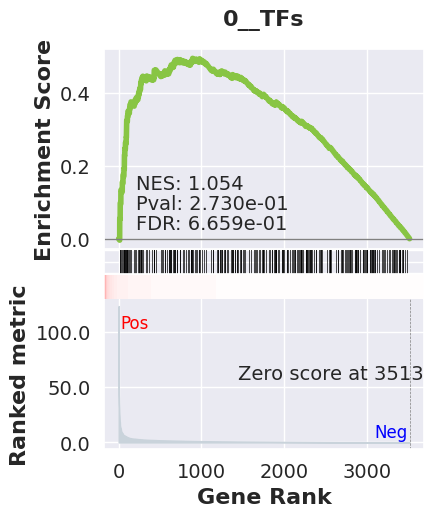

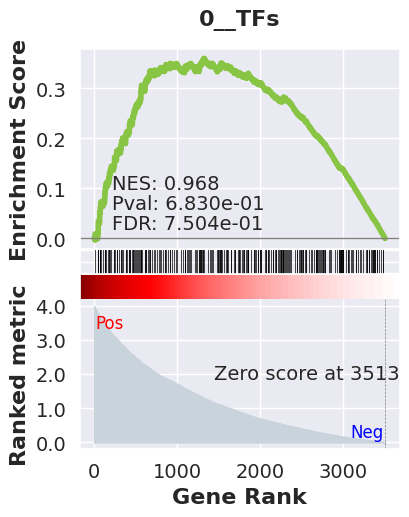

_________________________________________
TF specific enrichment


found some significant results for  16.666666666666668 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2393 genes
intersection pct: 0.6802160318362707
precision:  0.0009929287901819144 
recall:  0.9912264995523724 
random precision: 0.0009757067366217241


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

  9%|██████                                                          | 12/128 [00:00<00:01, 108.68it/s]

 20%|████████████▌                                                   | 25/128 [00:00<00:00, 116.25it/s]

 30%|███████████████████                                             | 38/128 [00:00<00:00, 119.19it/s]

 39%|█████████████████████████                                       | 50/128 [00:00<00:00, 109.80it/s]

 48%|███████████████████████████████                                 | 62/128 [00:00<00:00, 111.04it/s]

 58%|█████████████████████████████████████                           | 74/128 [00:00<00:00, 107.77it/s]

 67%|███████████████████████████████████████████                     | 86/128 [00:00<00:00, 110.12it/s]

 77%|█████████████████████████████████████████████████               | 98/128 [00:00<00:00, 111.75it/s]

 86%|██████████████████████████████████████████████████████▏        | 110/128 [00:00<00:00, 110.06it/s]

 95%|████████████████████████████████████████████████████████████   | 122/128 [00:01<00:00, 111.16it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 110.81it/s]

Average Precision (AP):  0.001369335100674096
Area Under Precision-Recall Curve (AUPRC):  0.0013638396248211383
EPR: 2.762088354837566


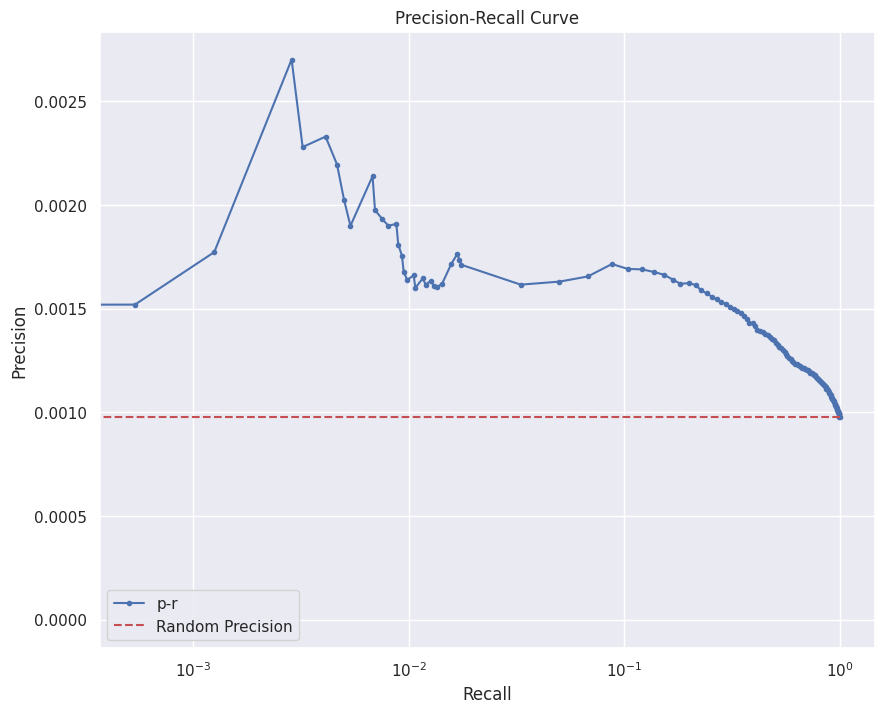

base enrichment


Top central genes: []


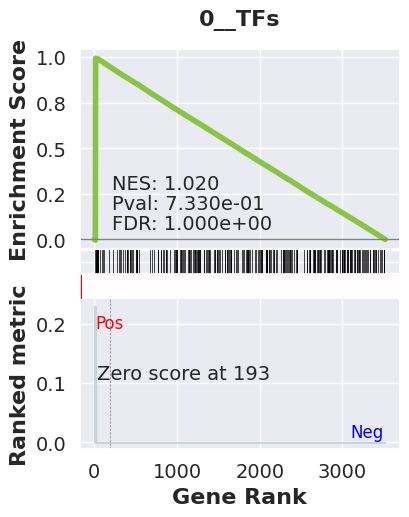

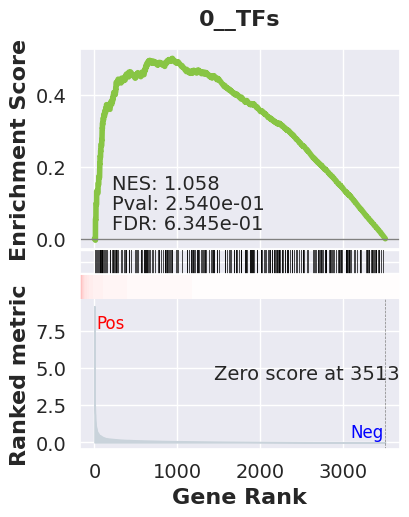

_________________________________________
TF specific enrichment


found some significant results for  6.666666666666667 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2393 genes
intersection pct: 0.6802160318362707
precision:  0.0044479937954613954 
recall:  0.41486123545210385 
random precision: 0.0009757067366217241


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

  9%|██████                                                          | 12/128 [00:00<00:01, 111.41it/s]

 19%|████████████                                                    | 24/128 [00:00<00:00, 109.12it/s]

 29%|██████████████████▌                                             | 37/128 [00:00<00:00, 116.93it/s]

 39%|█████████████████████████                                       | 50/128 [00:00<00:00, 117.90it/s]

 48%|███████████████████████████████                                 | 62/128 [00:00<00:00, 115.23it/s]

 59%|█████████████████████████████████████▌                          | 75/128 [00:00<00:00, 118.02it/s]

 68%|███████████████████████████████████████████▌                    | 87/128 [00:00<00:00, 113.12it/s]

 78%|█████████████████████████████████████████████████▏             | 100/128 [00:00<00:00, 116.27it/s]

 88%|███████████████████████████████████████████████████████▏       | 112/128 [00:00<00:00, 114.03it/s]

 97%|█████████████████████████████████████████████████████████████  | 124/128 [00:01<00:00, 113.85it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 114.55it/s]

Average Precision (AP):  0.0033901442193911635
Area Under Precision-Recall Curve (AUPRC):  0.002872536490843387
EPR: 6.1160790708647195


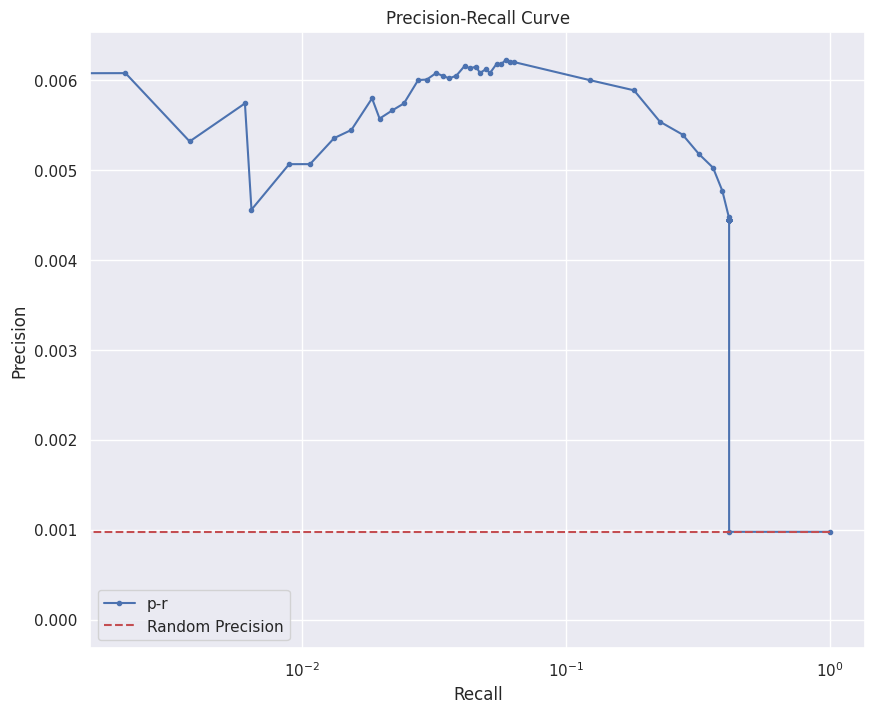

/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


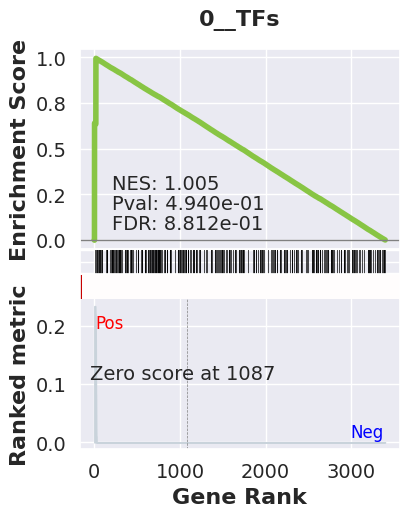

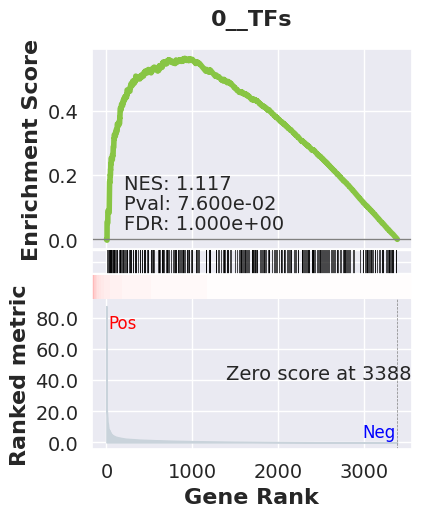

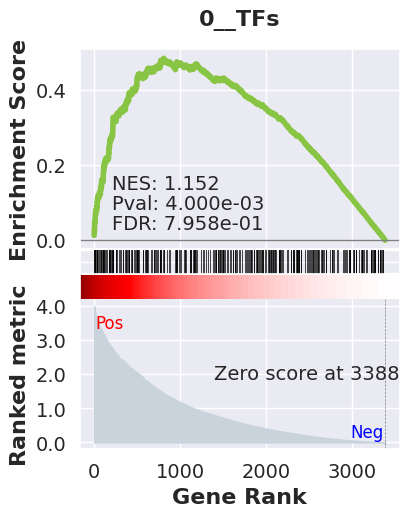

_________________________________________
TF specific enrichment


found some significant results for  55.172413793103445 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2353 genes
intersection pct: 0.6928739693757362
precision:  0.0020541996158759184 
recall:  0.9606902279228569 
random precision: 0.0019581674573781916


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

  9%|██████                                                          | 12/128 [00:00<00:01, 111.51it/s]

 20%|████████████▌                                                   | 25/128 [00:00<00:00, 115.77it/s]

 29%|██████████████████▌                                             | 37/128 [00:00<00:00, 111.11it/s]

 38%|████████████████████████▉                                        | 49/128 [00:00<00:00, 81.21it/s]

 45%|█████████████████████████████▍                                   | 58/128 [00:00<00:00, 77.27it/s]

 52%|██████████████████████████████████                               | 67/128 [00:00<00:00, 74.36it/s]

 59%|██████████████████████████████████████                           | 75/128 [00:00<00:00, 72.84it/s]

 65%|██████████████████████████████████████████▏                      | 83/128 [00:01<00:00, 70.10it/s]

 71%|██████████████████████████████████████████████▏                  | 91/128 [00:01<00:00, 69.30it/s]

 77%|██████████████████████████████████████████████████▎              | 99/128 [00:01<00:00, 67.48it/s]

 83%|█████████████████████████████████████████████████████           | 106/128 [00:01<00:00, 67.47it/s]

 88%|████████████████████████████████████████████████████████▌       | 113/128 [00:01<00:00, 66.81it/s]

 94%|████████████████████████████████████████████████████████████    | 120/128 [00:01<00:00, 65.97it/s]

 99%|███████████████████████████████████████████████████████████████▌| 127/128 [00:01<00:00, 65.08it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 73.60it/s]

Average Precision (AP):  0.0029663295301957846
Area Under Precision-Recall Curve (AUPRC):  0.002957147003015086
EPR: 2.2254289532837275


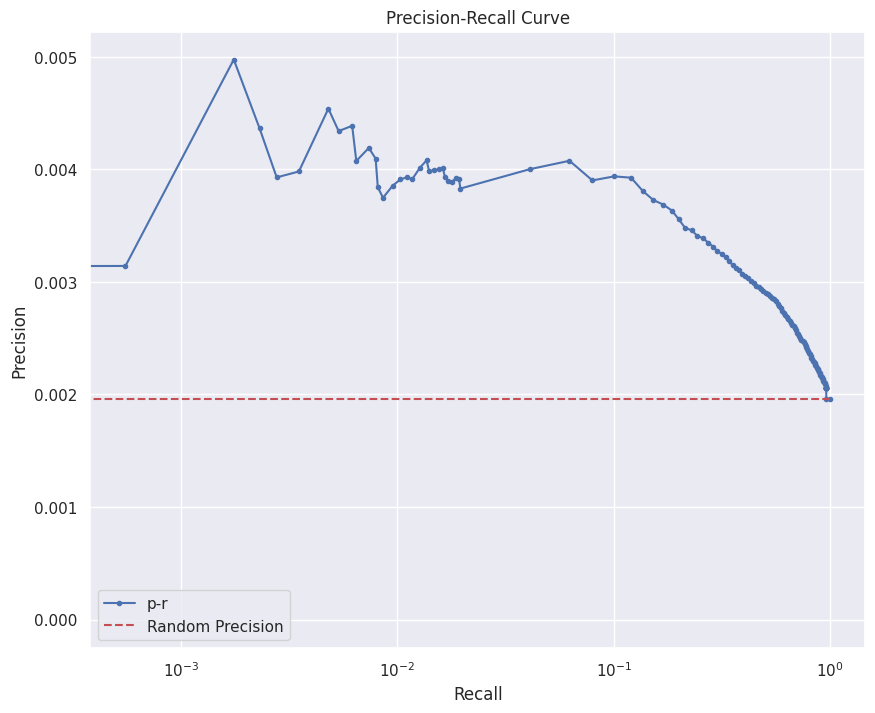

base enrichment


Top central genes: []


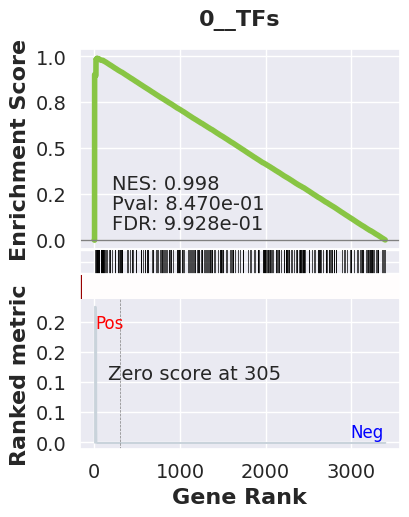

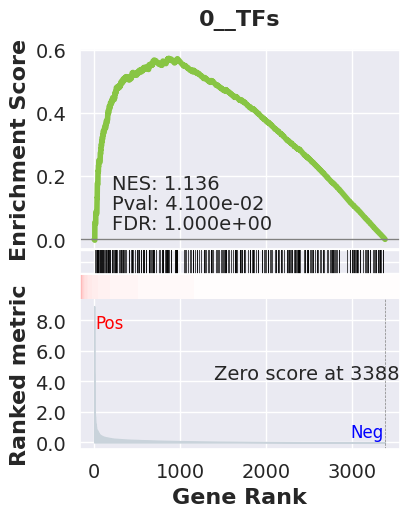

_________________________________________
TF specific enrichment


found some significant results for  10.344827586206897 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2353 genes
intersection pct: 0.6928739693757362
precision:  0.011322159233555305 
recall:  0.5950908923133709 
random precision: 0.0019581674573781916


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

  9%|█████▌                                                          | 11/128 [00:00<00:01, 104.79it/s]

 19%|████████████                                                    | 24/128 [00:00<00:00, 116.99it/s]

 28%|██████████████████                                              | 36/128 [00:00<00:00, 114.22it/s]

 38%|████████████████████████                                        | 48/128 [00:00<00:00, 114.85it/s]

 47%|██████████████████████████████                                  | 60/128 [00:00<00:00, 111.41it/s]

 57%|████████████████████████████████████▌                           | 73/128 [00:00<00:00, 114.84it/s]

 67%|███████████████████████████████████████████                     | 86/128 [00:00<00:00, 118.33it/s]

 77%|█████████████████████████████████████████████████               | 98/128 [00:00<00:00, 114.67it/s]

 86%|██████████████████████████████████████████████████████▏        | 110/128 [00:00<00:00, 116.08it/s]

 95%|████████████████████████████████████████████████████████████   | 122/128 [00:01<00:00, 113.65it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 114.19it/s]

Average Precision (AP):  0.010290854815907715
Area Under Precision-Recall Curve (AUPRC):  0.009552094589201776
EPR: 8.63686564191697


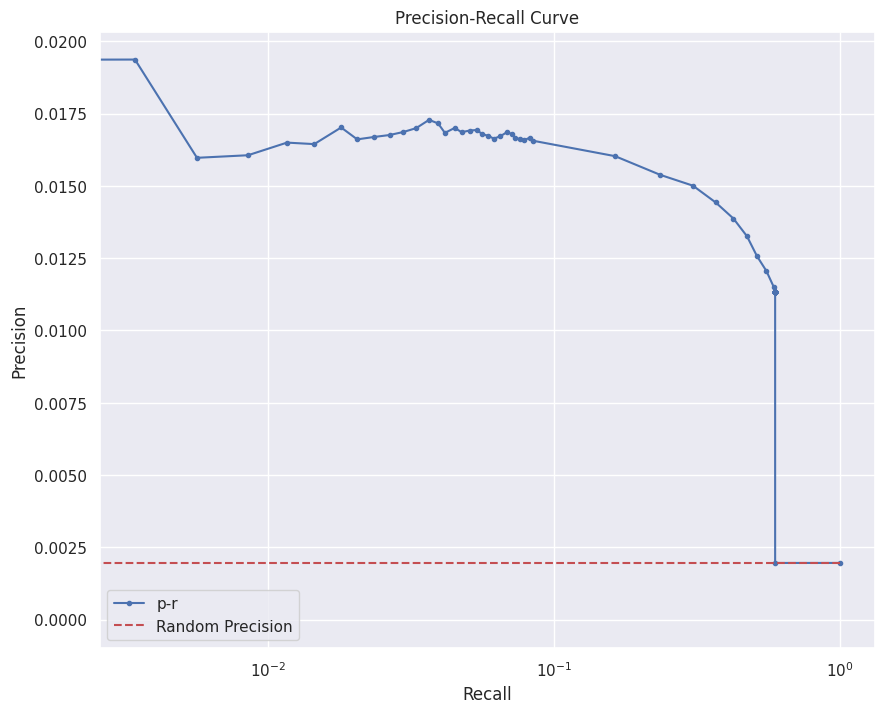

/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


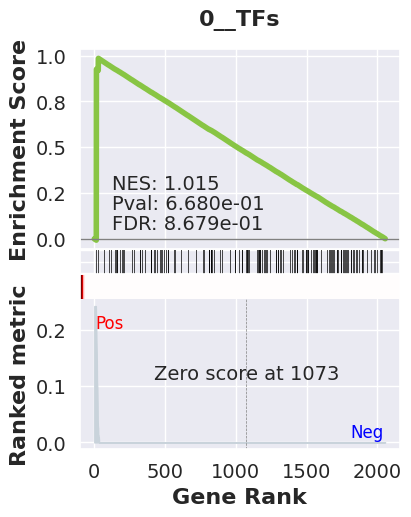

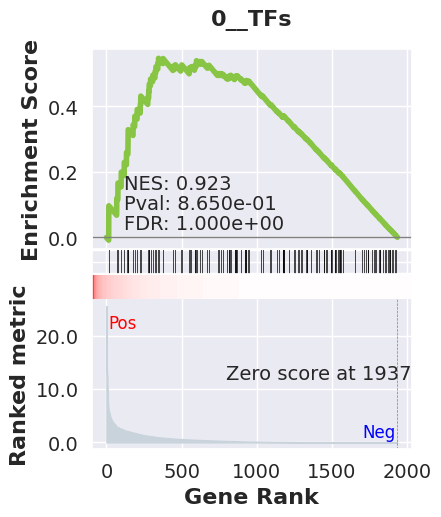

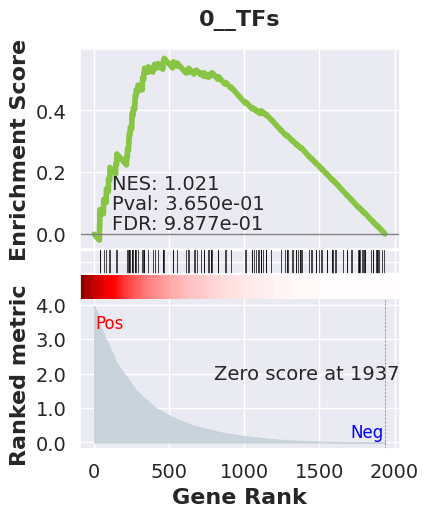

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1336 genes
intersection pct: 0.6498054474708171
precision:  0.001450179688632275 
recall:  0.81591796875 
random precision: 0.0011482652672183723


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

 27%|█████████████████                                               | 34/128 [00:00<00:00, 335.44it/s]

 55%|███████████████████████████████████▌                            | 71/128 [00:00<00:00, 353.85it/s]

 84%|████████████████████████████████████████████████████▋          | 107/128 [00:00<00:00, 345.13it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 347.81it/s]

Average Precision (AP):  0.002287883472242043
Area Under Precision-Recall Curve (AUPRC):  0.002258839383857374
EPR: 2.5605334018903707


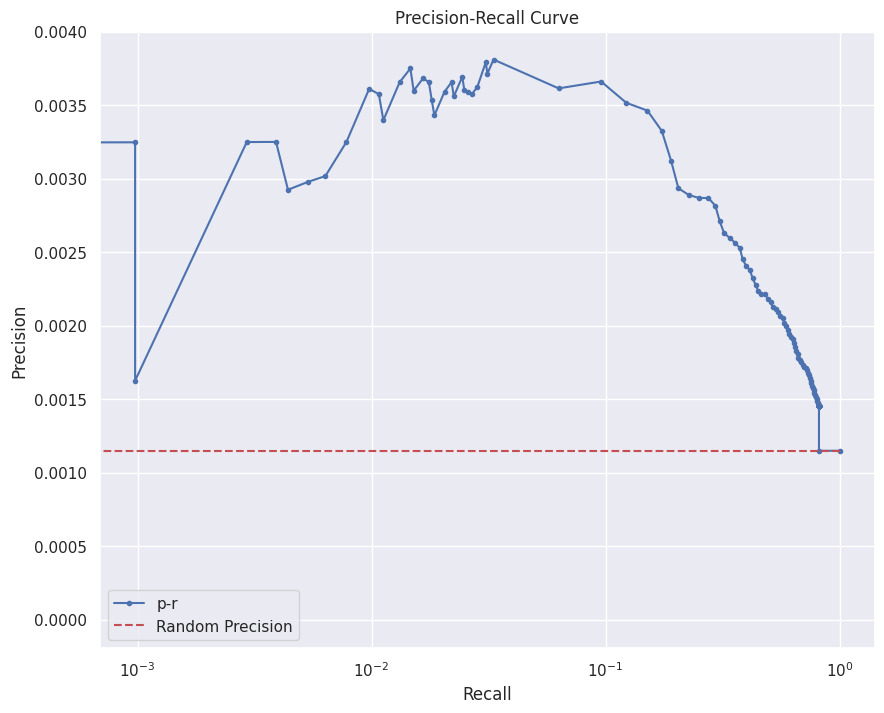

base enrichment


Top central genes: []


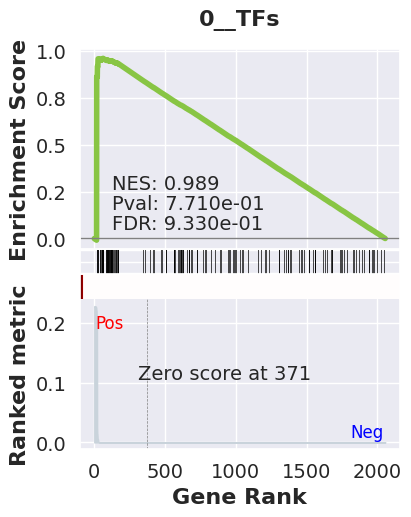

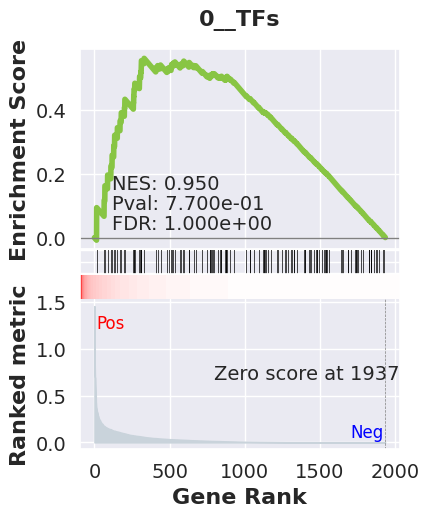

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1336 genes
intersection pct: 0.6498054474708171
precision:  0.007559670432345196 
recall:  0.34765625 
random precision: 0.0011482652672183723


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

 28%|██████████████████                                              | 36/128 [00:00<00:00, 352.93it/s]

 58%|█████████████████████████████████████                           | 74/128 [00:00<00:00, 368.29it/s]

 88%|███████████████████████████████████████████████████████▌       | 113/128 [00:00<00:00, 377.05it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 367.31it/s]

Average Precision (AP):  0.005124020683901259
Area Under Precision-Recall Curve (AUPRC):  0.00466265612017476
EPR: 12.211002842858543


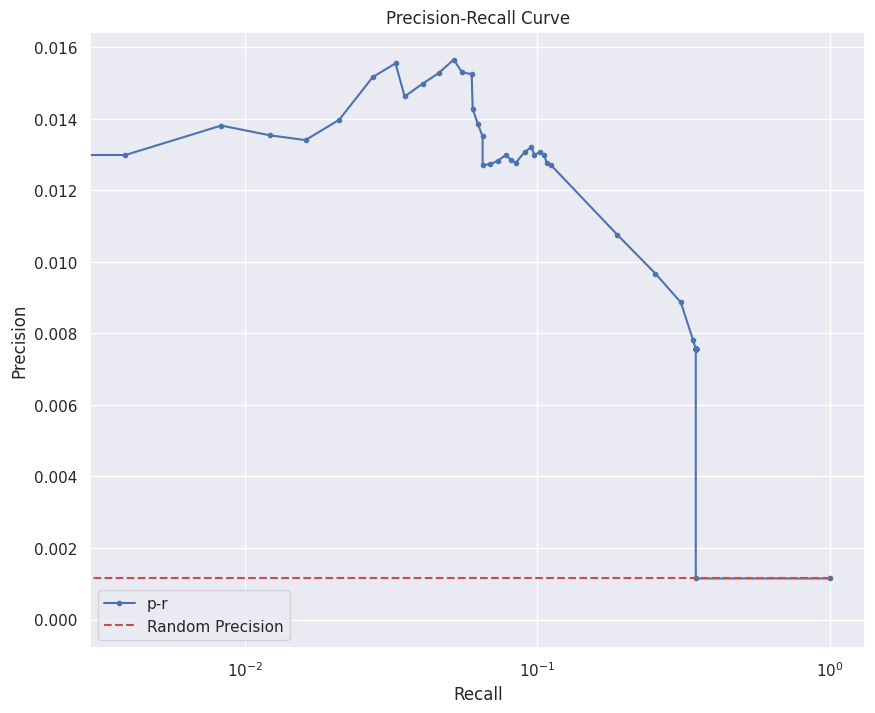

/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


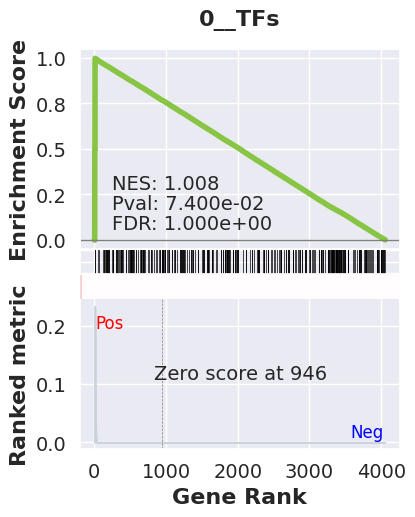

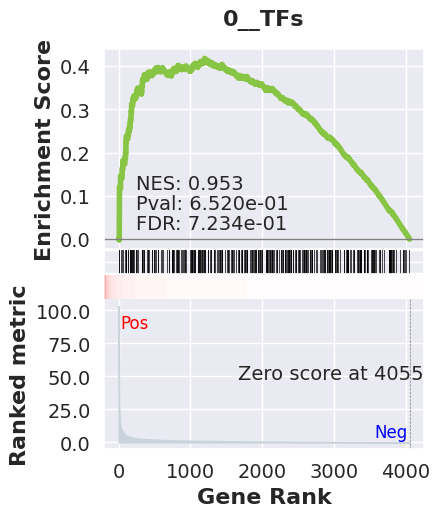

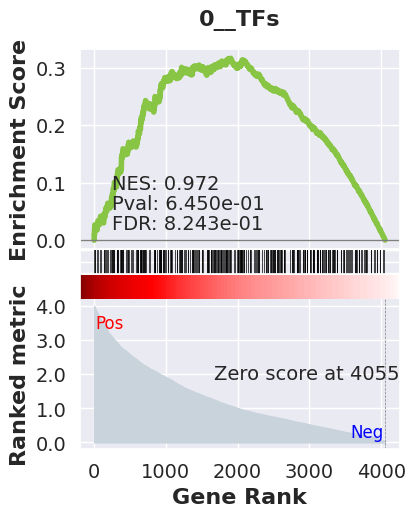

_________________________________________
TF specific enrichment


found some significant results for  18.181818181818183 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2847 genes
intersection pct: 0.7017500616218881
precision:  0.0008785837646198731 
recall:  0.9980287243030133 
random precision: 0.0008765128856773944


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

  5%|███▌                                                              | 7/128 [00:00<00:01, 64.99it/s]

 11%|███████                                                          | 14/128 [00:00<00:01, 67.30it/s]

 16%|██████████▋                                                      | 21/128 [00:00<00:01, 67.37it/s]

 22%|██████████████▏                                                  | 28/128 [00:00<00:01, 65.79it/s]

 28%|██████████████████▎                                              | 36/128 [00:00<00:01, 68.08it/s]

 34%|█████████████████████▊                                           | 43/128 [00:00<00:01, 67.63it/s]

 40%|█████████████████████████▉                                       | 51/128 [00:00<00:01, 68.77it/s]

 45%|█████████████████████████████▍                                   | 58/128 [00:00<00:01, 68.54it/s]

 52%|█████████████████████████████████▌                               | 66/128 [00:00<00:00, 70.45it/s]

 58%|█████████████████████████████████████▌                           | 74/128 [00:01<00:00, 68.74it/s]

 63%|█████████████████████████████████████████▏                       | 81/128 [00:01<00:00, 67.80it/s]

 70%|█████████████████████████████████████████████▏                   | 89/128 [00:01<00:00, 68.58it/s]

 75%|████████████████████████████████████████████████▊                | 96/128 [00:01<00:00, 67.19it/s]

 81%|████████████████████████████████████████████████████            | 104/128 [00:01<00:00, 69.48it/s]

 87%|███████████████████████████████████████████████████████▌        | 111/128 [00:01<00:00, 69.15it/s]

 93%|███████████████████████████████████████████████████████████▌    | 119/128 [00:01<00:00, 69.78it/s]

 98%|███████████████████████████████████████████████████████████████ | 126/128 [00:01<00:00, 69.14it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 68.55it/s]

Average Precision (AP):  0.0012848747453082139
Area Under Precision-Recall Curve (AUPRC):  0.0012836935803772036
EPR: 2.415614146651081


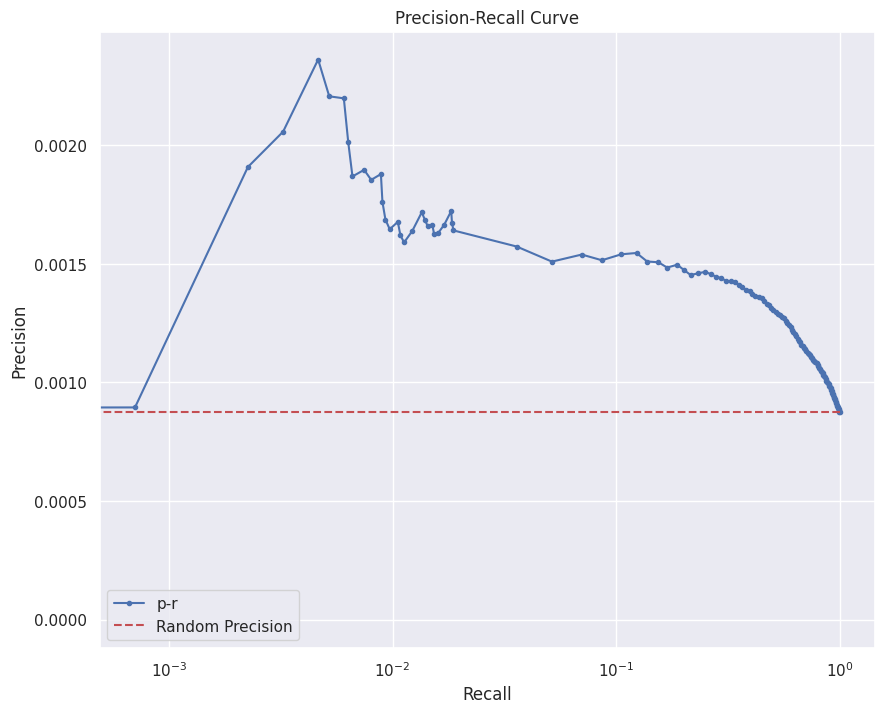

base enrichment


Top central genes: []


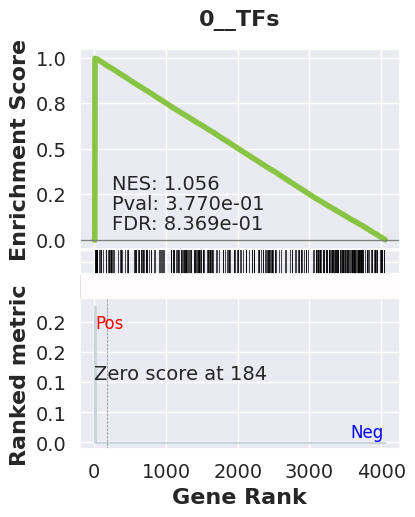

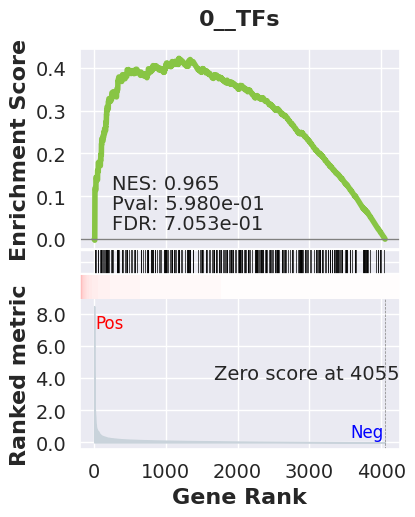

_________________________________________
TF specific enrichment


found some significant results for  6.0606060606060606 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2847 genes
intersection pct: 0.7017500616218881
precision:  0.0035227493289215345 
recall:  0.3756688256829062 
random precision: 0.0008765128856773944


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

  5%|███▌                                                              | 7/128 [00:00<00:01, 65.38it/s]

 12%|███████▌                                                         | 15/128 [00:00<00:01, 72.28it/s]

 18%|███████████▋                                                     | 23/128 [00:00<00:01, 71.06it/s]

 24%|███████████████▋                                                 | 31/128 [00:00<00:01, 72.62it/s]

 30%|███████████████████▊                                             | 39/128 [00:00<00:01, 70.58it/s]

 37%|███████████████████████▊                                         | 47/128 [00:00<00:01, 72.70it/s]

 43%|███████████████████████████▉                                     | 55/128 [00:00<00:01, 72.03it/s]

 49%|███████████████████████████████▉                                 | 63/128 [00:00<00:00, 69.65it/s]

 55%|████████████████████████████████████                             | 71/128 [00:00<00:00, 70.82it/s]

 62%|████████████████████████████████████████                         | 79/128 [00:01<00:00, 69.86it/s]

 68%|████████████████████████████████████████████▏                    | 87/128 [00:01<00:00, 71.96it/s]

 74%|████████████████████████████████████████████████▏                | 95/128 [00:01<00:00, 70.73it/s]

 80%|███████████████████████████████████████████████████▌            | 103/128 [00:01<00:00, 71.82it/s]

 87%|███████████████████████████████████████████████████████▌        | 111/128 [00:01<00:00, 70.55it/s]

 93%|███████████████████████████████████████████████████████████▌    | 119/128 [00:01<00:00, 71.83it/s]

 99%|███████████████████████████████████████████████████████████████▌| 127/128 [00:01<00:00, 71.36it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 71.05it/s]

Average Precision (AP):  0.0028800475077200593
Area Under Precision-Recall Curve (AUPRC):  0.002492912907750446
EPR: 7.473146959085978


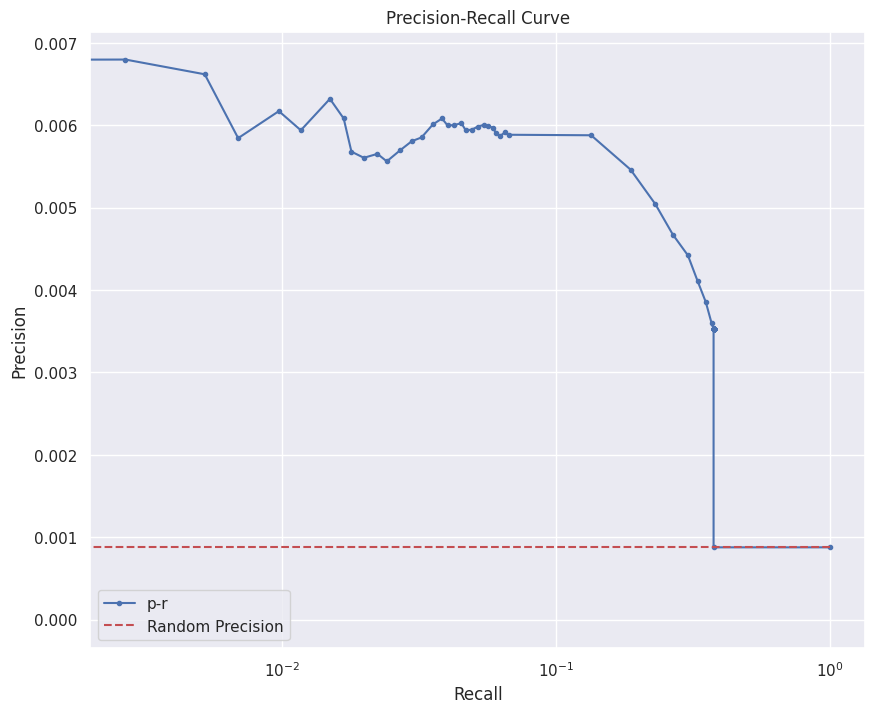

/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


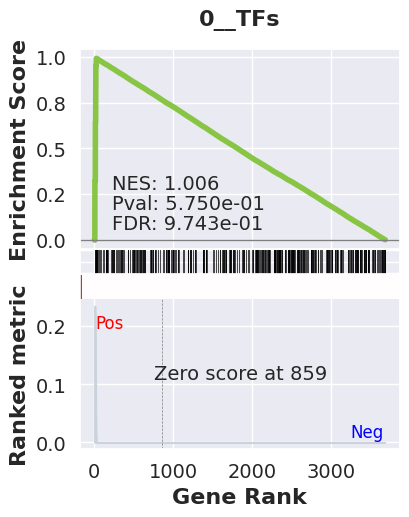

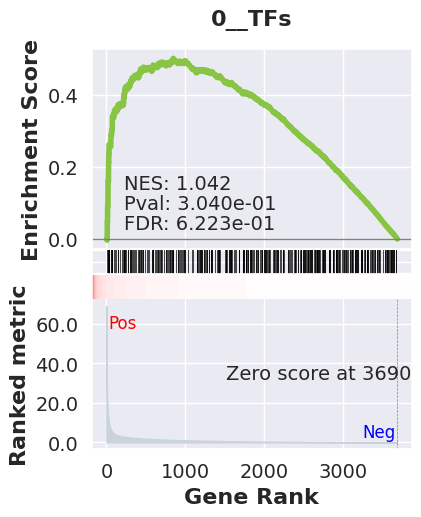

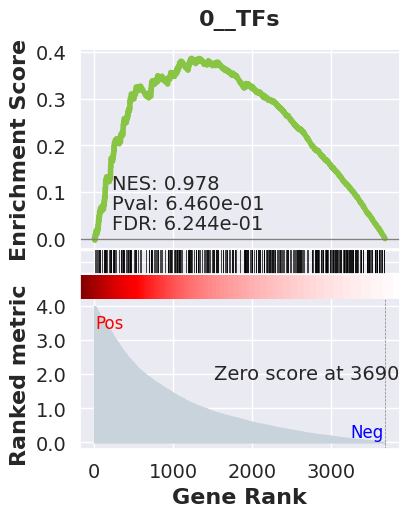

_________________________________________
TF specific enrichment


found some significant results for  5.882352941176471 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2632 genes
intersection pct: 0.7125067677314564
precision:  0.0008274642920948951 
recall:  0.9767441860465116 
random precision: 0.0008196636086686791


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

  7%|████▋                                                             | 9/128 [00:00<00:01, 83.28it/s]

 14%|█████████▏                                                       | 18/128 [00:00<00:01, 86.46it/s]

 22%|██████████████▏                                                  | 28/128 [00:00<00:01, 90.15it/s]

 30%|███████████████████▎                                             | 38/128 [00:00<00:01, 87.73it/s]

 37%|███████████████████████▊                                         | 47/128 [00:00<00:00, 88.30it/s]

 44%|████████████████████████████▍                                    | 56/128 [00:00<00:00, 87.83it/s]

 52%|█████████████████████████████████▌                               | 66/128 [00:00<00:00, 89.97it/s]

 59%|██████████████████████████████████████▌                          | 76/128 [00:00<00:00, 88.19it/s]

 66%|███████████████████████████████████████████▏                     | 85/128 [00:00<00:00, 88.30it/s]

 74%|████████████████████████████████████████████████▏                | 95/128 [00:01<00:00, 89.85it/s]

 81%|████████████████████████████████████████████████████            | 104/128 [00:01<00:00, 89.06it/s]

 89%|█████████████████████████████████████████████████████████       | 114/128 [00:01<00:00, 91.34it/s]

 97%|██████████████████████████████████████████████████████████████  | 124/128 [00:01<00:00, 89.55it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 88.97it/s]

Average Precision (AP):  0.0012400576016121014
Area Under Precision-Recall Curve (AUPRC):  0.0012395995558536444
EPR: 2.802497563967885


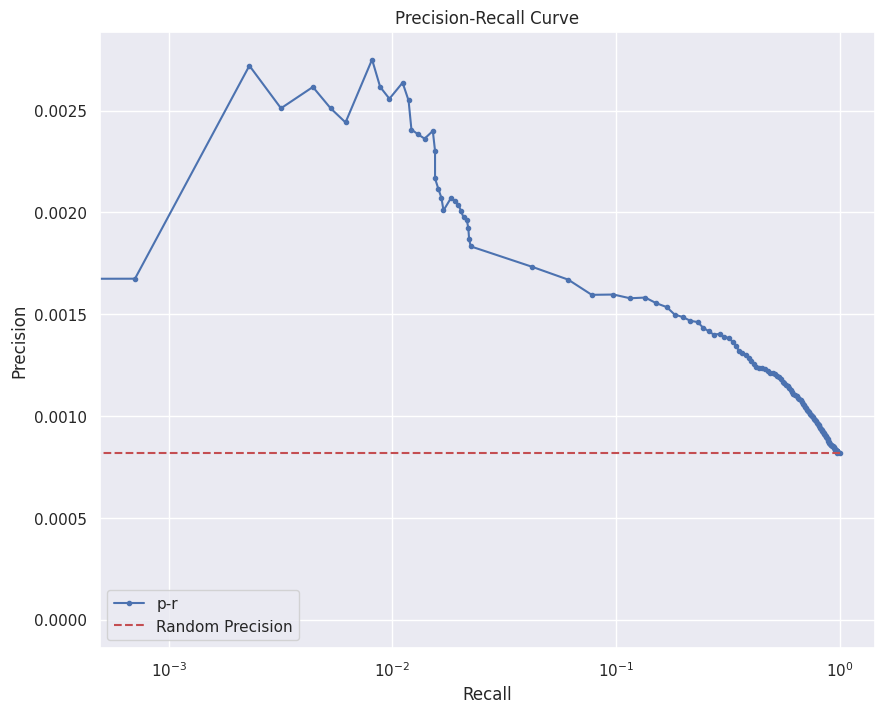

base enrichment


Top central genes: []


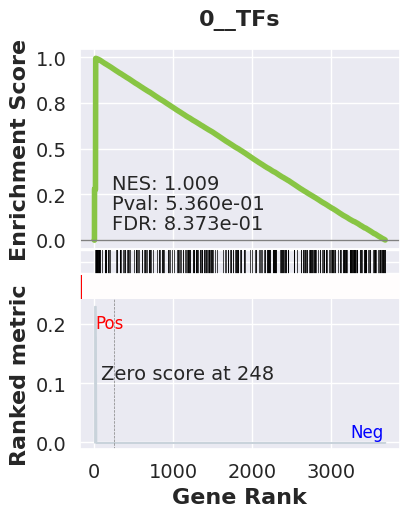

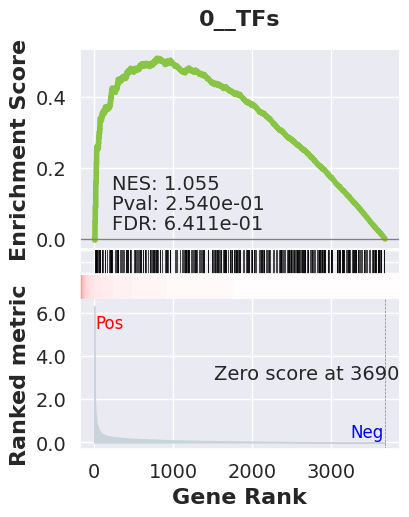

_________________________________________
TF specific enrichment


found some significant results for  17.647058823529413 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2632 genes
intersection pct: 0.7125067677314564
precision:  0.0026066729779271967 
recall:  0.350246652572234 
random precision: 0.0008196636086686791


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

  8%|█████                                                            | 10/128 [00:00<00:01, 95.80it/s]

 16%|██████████▏                                                      | 20/128 [00:00<00:01, 89.38it/s]

 24%|███████████████▋                                                 | 31/128 [00:00<00:01, 95.86it/s]

 32%|████████████████████▊                                            | 41/128 [00:00<00:00, 94.80it/s]

 40%|█████████████████████████▉                                       | 51/128 [00:00<00:00, 94.51it/s]

 48%|██████████████████████████████▉                                  | 61/128 [00:00<00:00, 92.74it/s]

 56%|████████████████████████████████████▌                            | 72/128 [00:00<00:00, 96.13it/s]

 65%|██████████████████████████████████████████▏                      | 83/128 [00:00<00:00, 98.52it/s]

 73%|███████████████████████████████████████████████▏                 | 93/128 [00:00<00:00, 94.62it/s]

 81%|████████████████████████████████████████████████████            | 104/128 [00:01<00:00, 97.68it/s]

 89%|█████████████████████████████████████████████████████████       | 114/128 [00:01<00:00, 94.96it/s]

 98%|██████████████████████████████████████████████████████████████▌ | 125/128 [00:01<00:00, 96.84it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 95.71it/s]

Average Precision (AP):  0.002139752926869064
Area Under Precision-Recall Curve (AUPRC):  0.0018317888079841572
EPR: 7.164569673341603


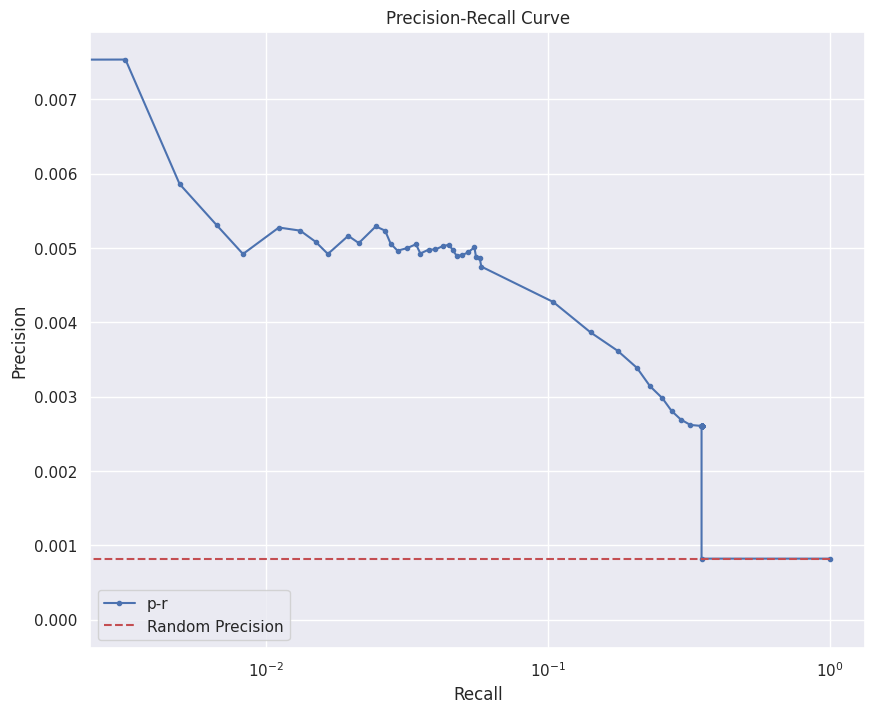

/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/70 [00:00<?, ?it/s]

base enrichment


Top central genes: []


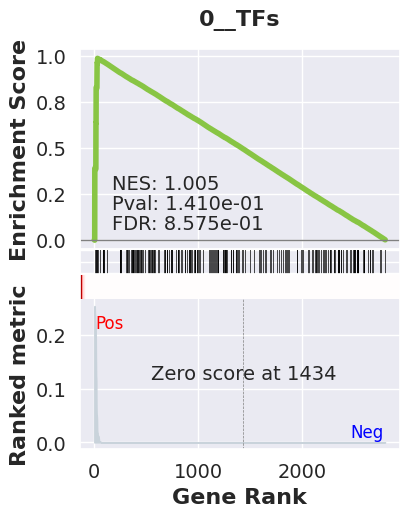

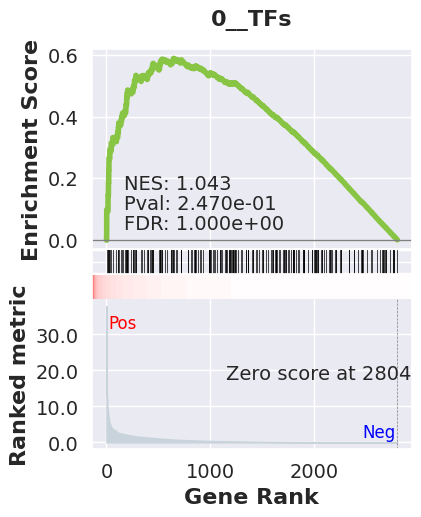

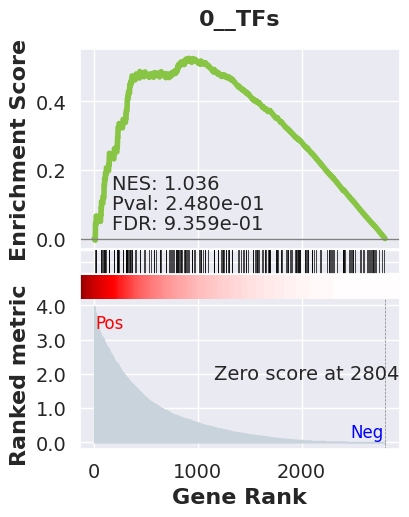

_________________________________________
TF specific enrichment


found some significant results for  12.5 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1975 genes
intersection pct: 0.7040998217468806
precision:  0.0022685365790974725 
recall:  0.8035326086956521 
random precision: 0.0018878329678221949


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

 14%|█████████                                                       | 18/128 [00:00<00:00, 172.46it/s]

 28%|██████████████████                                              | 36/128 [00:00<00:00, 163.13it/s]

 42%|███████████████████████████                                     | 54/128 [00:00<00:00, 169.46it/s]

 56%|████████████████████████████████████                            | 72/128 [00:00<00:00, 170.07it/s]

 70%|█████████████████████████████████████████████                   | 90/128 [00:00<00:00, 167.93it/s]

 84%|████████████████████████████████████████████████████▋          | 107/128 [00:00<00:00, 168.34it/s]

 97%|█████████████████████████████████████████████████████████████  | 124/128 [00:00<00:00, 167.91it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 168.26it/s]

Average Precision (AP):  0.0033271904695693663
Area Under Precision-Recall Curve (AUPRC):  0.003265948460153519
EPR: 4.81827065211826


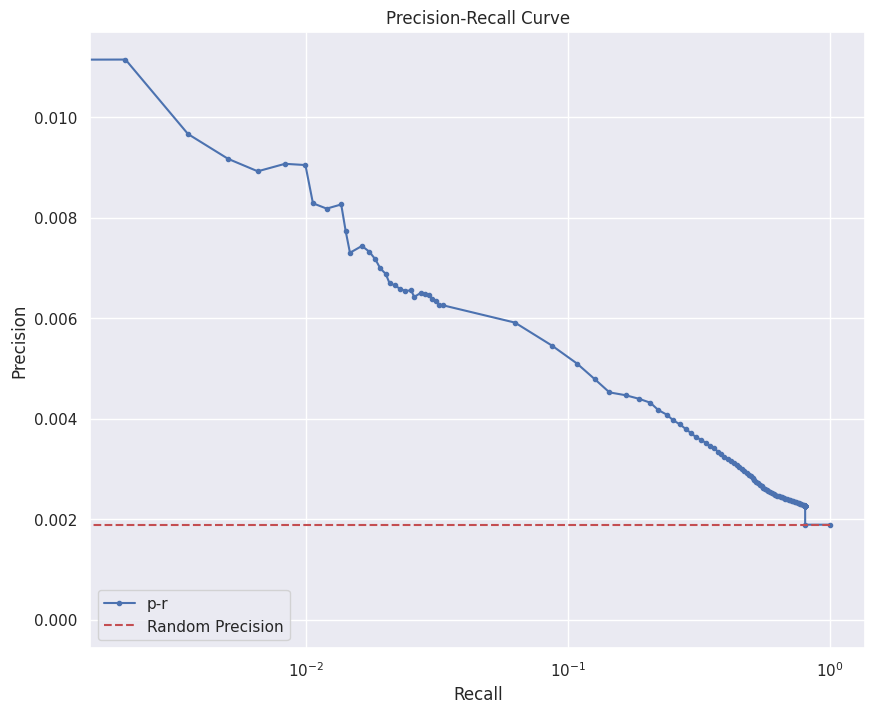

base enrichment


Top central genes: []


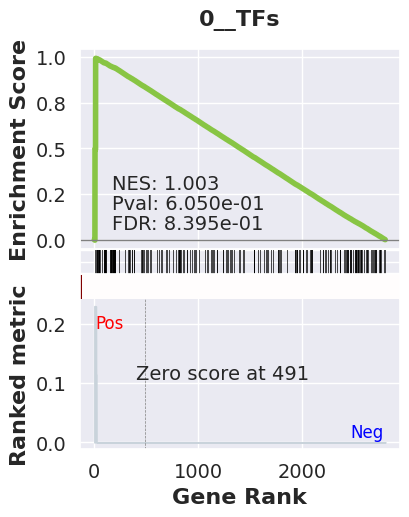

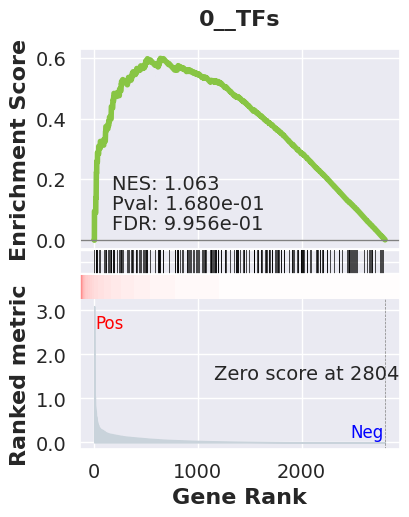

_________________________________________
TF specific enrichment


found some significant results for  6.25 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1975 genes
intersection pct: 0.7040998217468806
precision:  0.009553283100107642 
recall:  0.3279891304347826 
random precision: 0.0018878329678221949


  0%|                                                                          | 0/128 [00:00<?, ?it/s]

 14%|█████████                                                       | 18/128 [00:00<00:00, 174.68it/s]

 28%|██████████████████                                              | 36/128 [00:00<00:00, 168.03it/s]

 41%|██████████████████████████▌                                     | 53/128 [00:00<00:00, 168.84it/s]

 55%|███████████████████████████████████                             | 70/128 [00:00<00:00, 165.10it/s]

 70%|████████████████████████████████████████████▌                   | 89/128 [00:00<00:00, 170.99it/s]

 84%|█████████████████████████████████████████████████████▏         | 108/128 [00:00<00:00, 176.00it/s]

 98%|██████████████████████████████████████████████████████████████ | 126/128 [00:00<00:00, 167.92it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 169.16it/s]

Average Precision (AP):  0.0063683520242025365
Area Under Precision-Recall Curve (AUPRC):  0.00527954159624555
EPR: 12.851376814638197


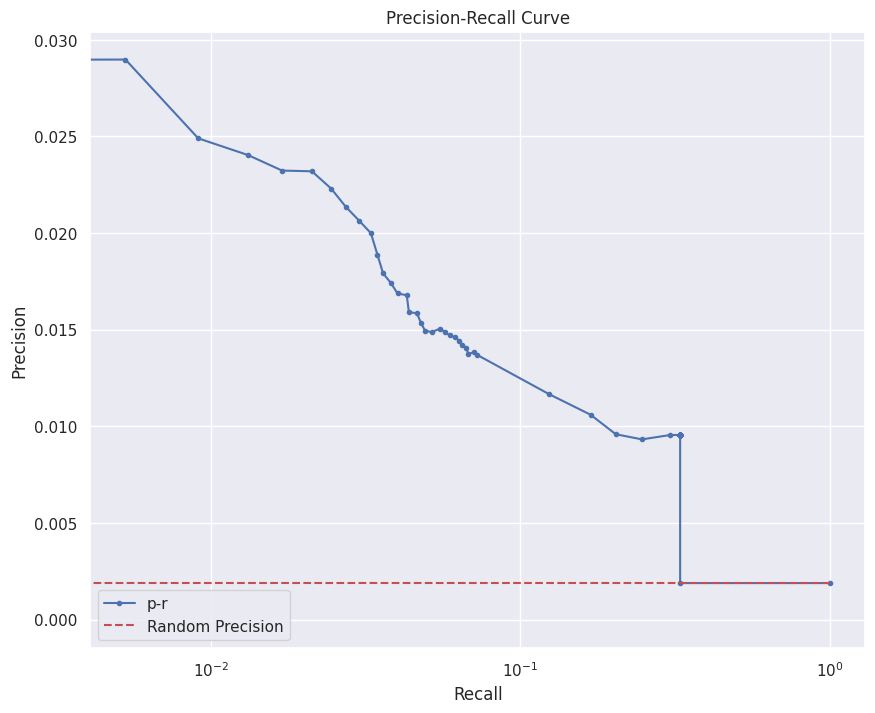

/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


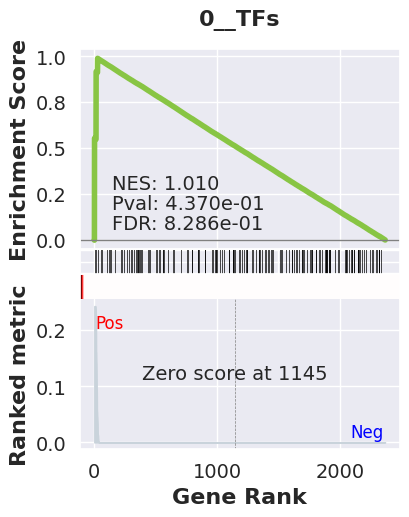

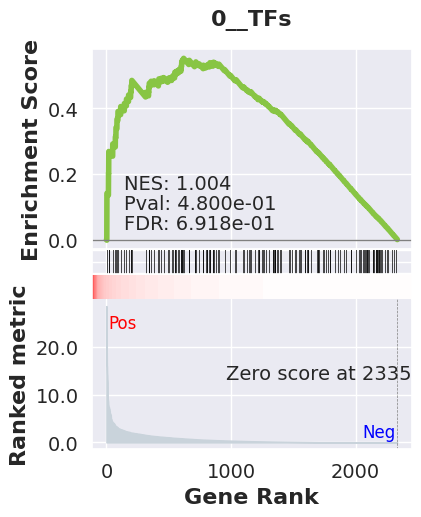

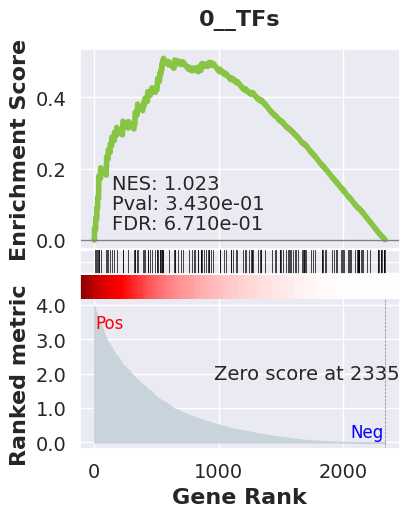

_________________________________________
TF specific enrichment


found some significant results for  11.764705882352942 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1538 genes
intersection pct: 0.6486714466469844
precision:  0.0014463819419052765 
recall:  0.8925124792013311 
random precision: 0.0012712011391315897


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

 22%|██████████████▉                                                     | 28/128 [00:00<00:00, 277.29it/s]

 44%|█████████████████████████████▊                                      | 56/128 [00:00<00:00, 265.22it/s]

 67%|█████████████████████████████████████████████▋                      | 86/128 [00:00<00:00, 278.17it/s]

 91%|████████████████████████████████████████████████████████████▋      | 116/128 [00:00<00:00, 286.19it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 280.44it/s]

Average Precision (AP):  0.0022888854588018776
Area Under Precision-Recall Curve (AUPRC):  0.002264231896196686
EPR: 2.893448553754135


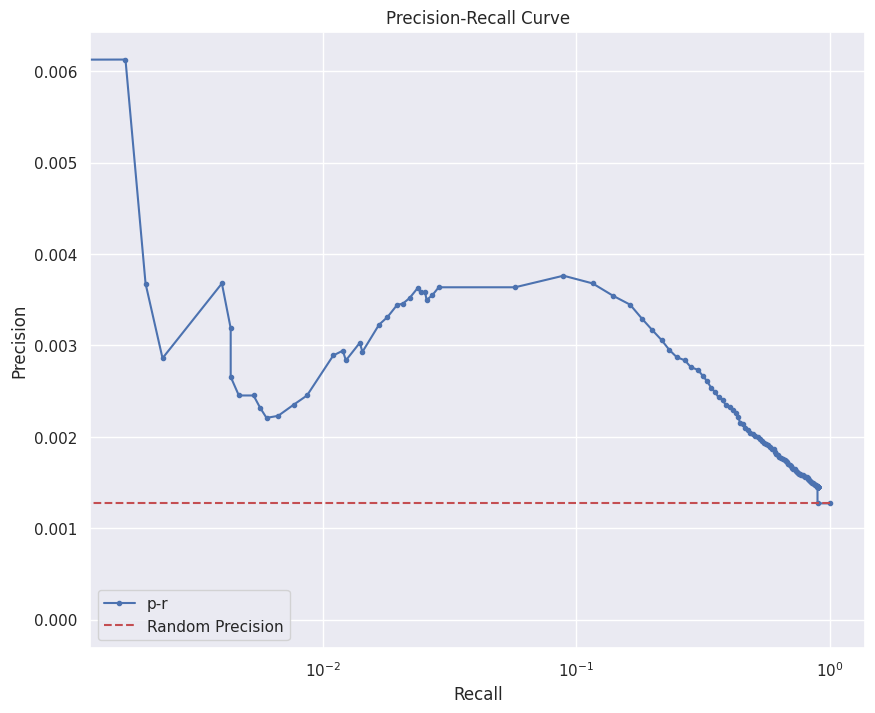

base enrichment


Top central genes: []


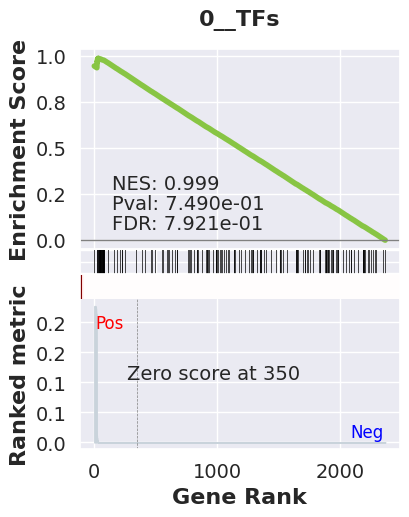

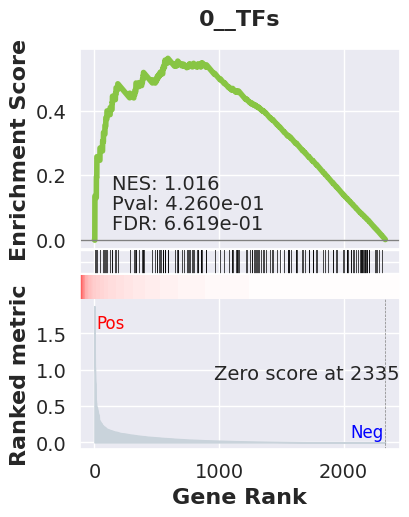

_________________________________________
TF specific enrichment


found some significant results for  5.882352941176471 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1538 genes
intersection pct: 0.6486714466469844
precision:  0.010407643910856851 
recall:  0.5158069883527454 
random precision: 0.0012712011391315897


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

 23%|███████████████▍                                                    | 29/128 [00:00<00:00, 282.36it/s]

 45%|██████████████████████████████▊                                     | 58/128 [00:00<00:00, 272.56it/s]

 69%|██████████████████████████████████████████████▊                     | 88/128 [00:00<00:00, 283.72it/s]

 91%|█████████████████████████████████████████████████████████████▏     | 117/128 [00:00<00:00, 279.34it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 278.35it/s]

Average Precision (AP):  0.00995539507430573
Area Under Precision-Recall Curve (AUPRC):  0.0093514384476144
EPR: 21.46783110582073


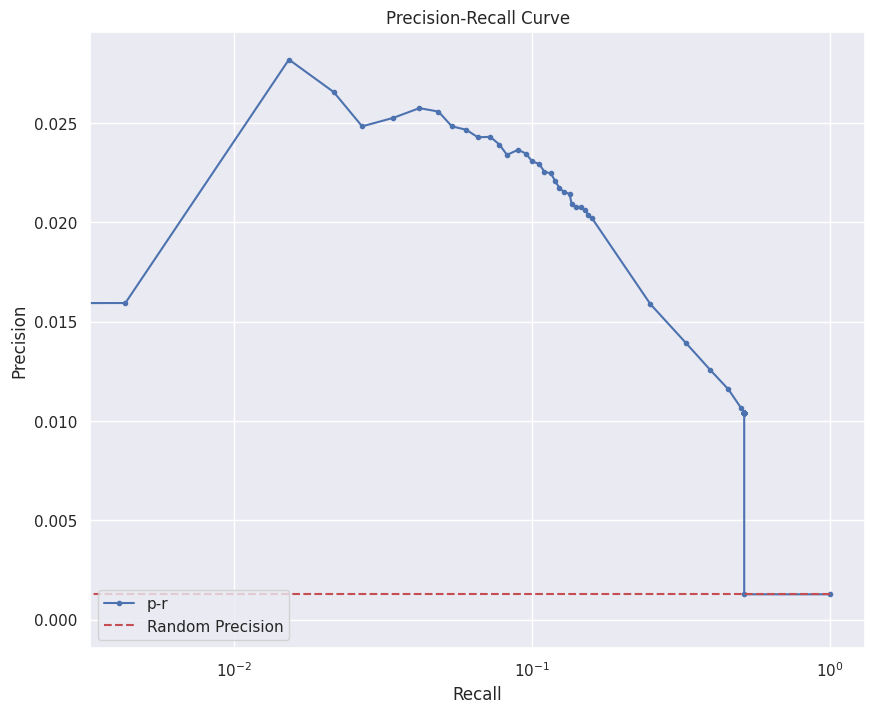

/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment


Top central genes: []


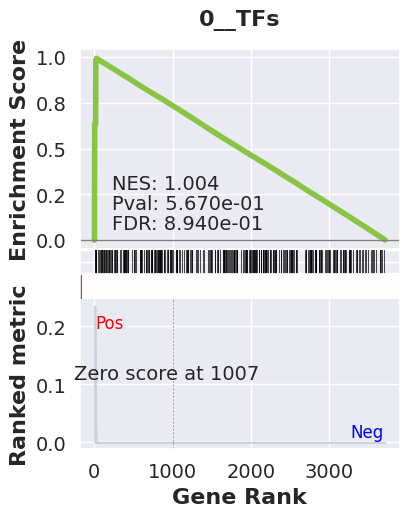

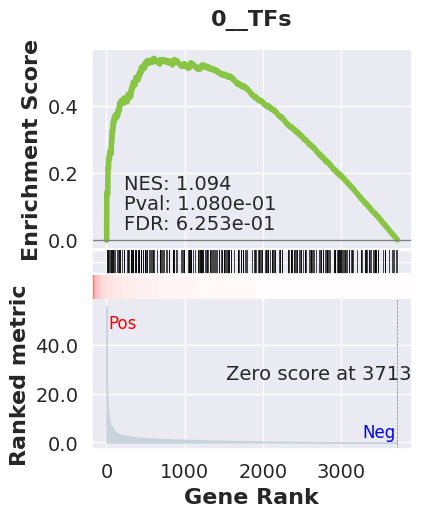

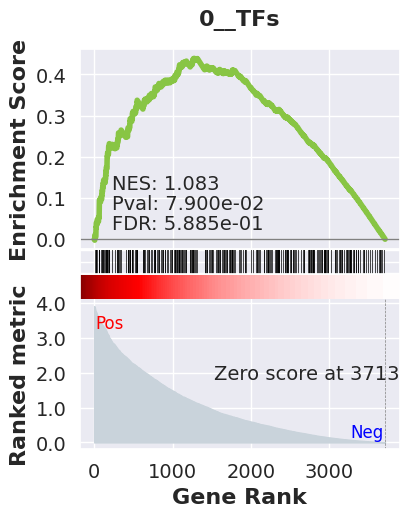

_________________________________________
TF specific enrichment


found some significant results for  5.882352941176471 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2686 genes
intersection pct: 0.7230148048452221
precision:  0.0021536955602455693 
recall:  0.9650715800636267 
random precision: 0.0020920948819383492


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  7%|████▉                                                                 | 9/128 [00:00<00:01, 89.75it/s]

 15%|██████████▏                                                          | 19/128 [00:00<00:01, 92.72it/s]

 23%|███████████████▋                                                     | 29/128 [00:00<00:01, 87.01it/s]

 30%|████████████████████▍                                                | 38/128 [00:00<00:01, 87.52it/s]

 37%|█████████████████████████▎                                           | 47/128 [00:00<00:00, 86.84it/s]

 44%|██████████████████████████████▏                                      | 56/128 [00:00<00:00, 86.61it/s]

 52%|███████████████████████████████████▌                                 | 66/128 [00:00<00:00, 87.88it/s]

 59%|████████████████████████████████████████▍                            | 75/128 [00:00<00:00, 85.43it/s]

 66%|█████████████████████████████████████████████▎                       | 84/128 [00:00<00:00, 85.48it/s]

 73%|██████████████████████████████████████████████████▏                  | 93/128 [00:01<00:00, 85.21it/s]

 80%|██████████████████████████████████████████████████████▋             | 103/128 [00:01<00:00, 88.13it/s]

 88%|███████████████████████████████████████████████████████████▌        | 112/128 [00:01<00:00, 87.07it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 121/128 [00:01<00:00, 86.89it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 87.36it/s]

Average Precision (AP):  0.002856791344133237
Area Under Precision-Recall Curve (AUPRC):  0.002855484123361965
EPR: 1.811890168519223


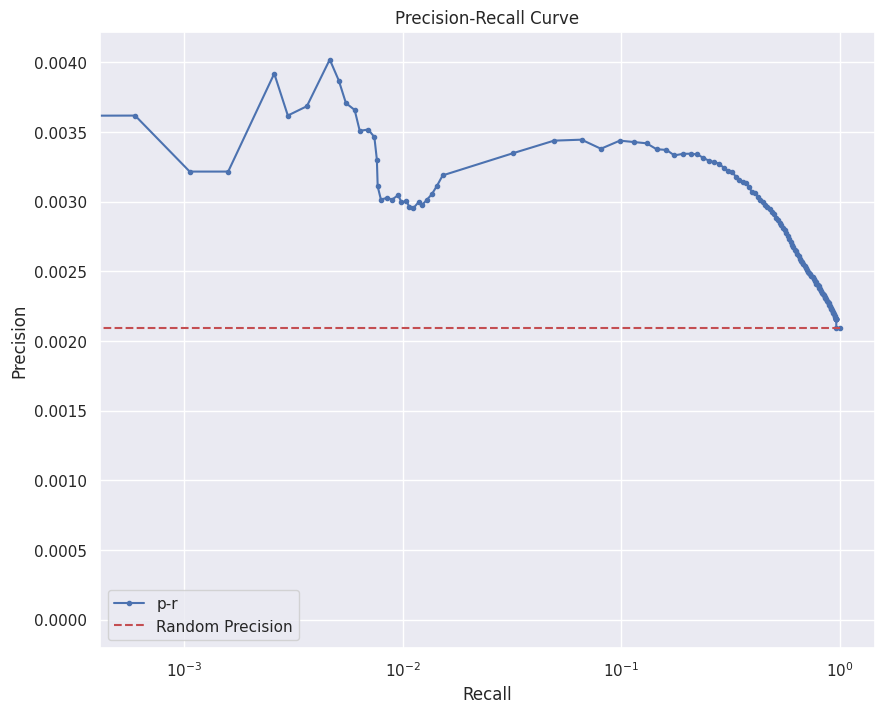

base enrichment


Top central genes: []


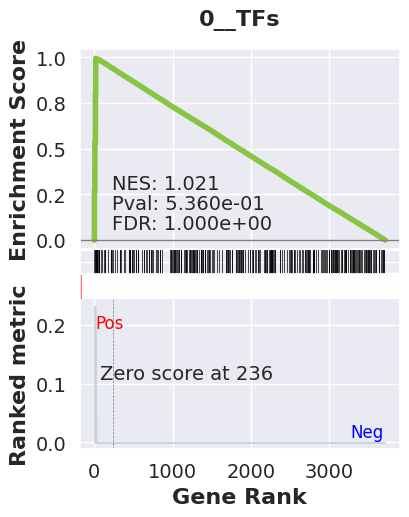

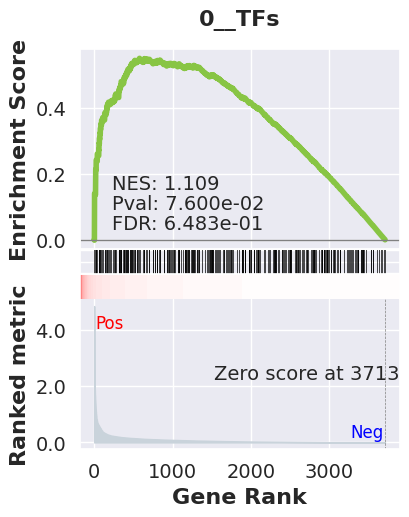

_________________________________________
TF specific enrichment


found some significant results for  8.823529411764707 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2686 genes
intersection pct: 0.7230148048452221
precision:  0.01151774020046899 
recall:  0.5088149522799575 
random precision: 0.0020920948819383492


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  7%|████▉                                                                 | 9/128 [00:00<00:01, 81.81it/s]

 14%|█████████▋                                                           | 18/128 [00:00<00:01, 81.29it/s]

 21%|██████████████▌                                                      | 27/128 [00:00<00:01, 81.33it/s]

 29%|███████████████████▉                                                 | 37/128 [00:00<00:01, 85.95it/s]

 37%|█████████████████████████▎                                           | 47/128 [00:00<00:00, 89.18it/s]

 44%|██████████████████████████████▏                                      | 56/128 [00:00<00:00, 85.33it/s]

 52%|███████████████████████████████████▌                                 | 66/128 [00:00<00:00, 88.13it/s]

 59%|████████████████████████████████████████▍                            | 75/128 [00:00<00:00, 84.90it/s]

 66%|█████████████████████████████████████████████▊                       | 85/128 [00:00<00:00, 86.89it/s]

 73%|██████████████████████████████████████████████████▋                  | 94/128 [00:01<00:00, 86.13it/s]

 80%|██████████████████████████████████████████████████████▋             | 103/128 [00:01<00:00, 85.02it/s]

 88%|███████████████████████████████████████████████████████████▌        | 112/128 [00:01<00:00, 84.38it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 121/128 [00:01<00:00, 85.74it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 85.97it/s]

Average Precision (AP):  0.008976287650307207
Area Under Precision-Recall Curve (AUPRC):  0.00814212745461767
EPR: 9.068951329000031


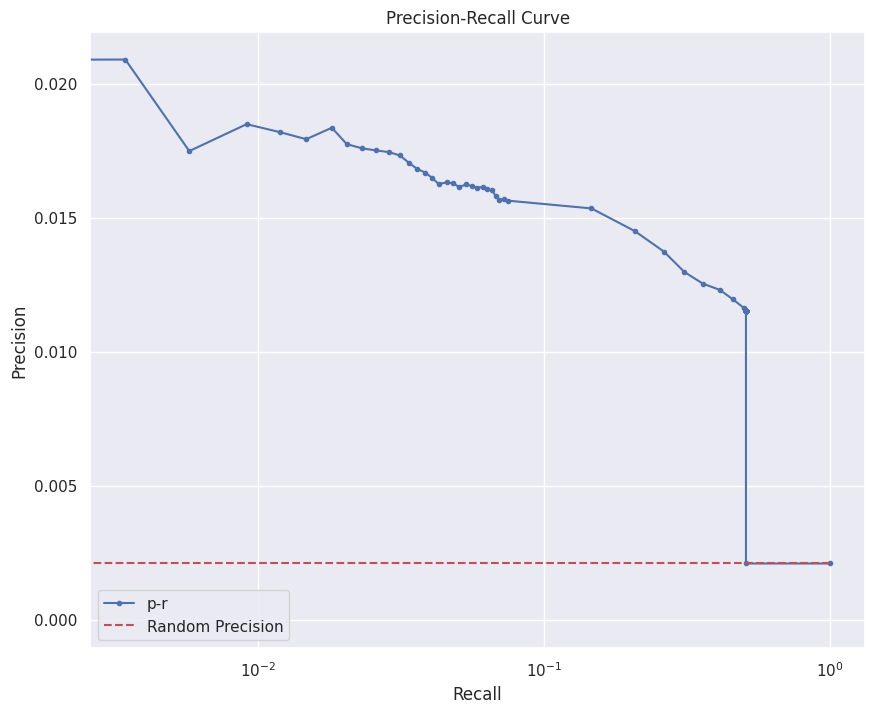

/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/43 [00:00<?, ?it/s]

base enrichment


Top central genes: []


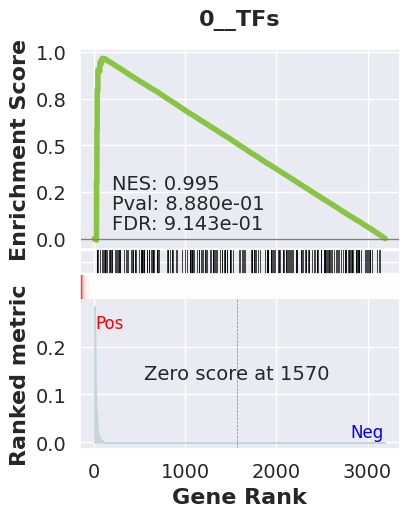

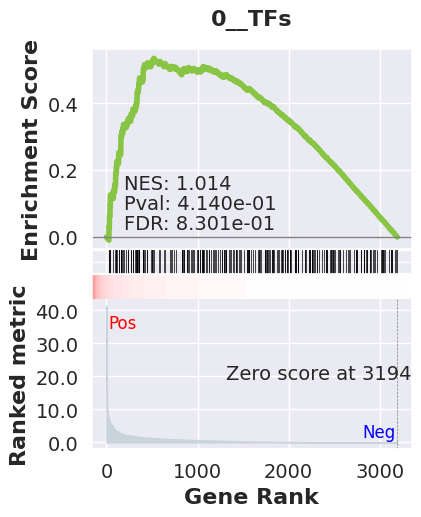

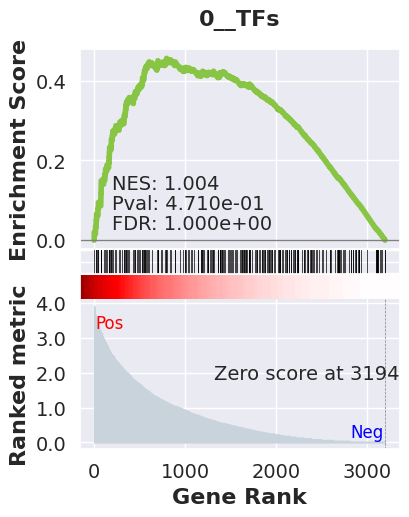

_________________________________________
TF specific enrichment


found some significant results for  18.42105263157895 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2272 genes
intersection pct: 0.7111111111111111
precision:  0.002399294661392362 
recall:  0.8595452837279218 
random precision: 0.002062905836604834


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  4%|██▋                                                                   | 5/128 [00:00<00:02, 48.11it/s]

 10%|███████                                                              | 13/128 [00:00<00:01, 63.55it/s]

 16%|███████████▎                                                         | 21/128 [00:00<00:01, 68.57it/s]

 23%|███████████████▋                                                     | 29/128 [00:00<00:01, 69.51it/s]

 29%|███████████████████▉                                                 | 37/128 [00:00<00:01, 71.08it/s]

 35%|████████████████████████▎                                            | 45/128 [00:00<00:01, 70.06it/s]

 41%|████████████████████████████▌                                        | 53/128 [00:00<00:01, 70.26it/s]

 48%|████████████████████████████████▉                                    | 61/128 [00:00<00:00, 70.61it/s]

 54%|█████████████████████████████████████▏                               | 69/128 [00:01<00:00, 69.51it/s]

 59%|████████████████████████████████████████▉                            | 76/128 [00:01<00:00, 69.39it/s]

 65%|████████████████████████████████████████████▋                        | 83/128 [00:01<00:00, 69.37it/s]

 71%|█████████████████████████████████████████████████                    | 91/128 [00:01<00:00, 70.23it/s]

 77%|█████████████████████████████████████████████████████▎               | 99/128 [00:01<00:00, 69.44it/s]

 84%|████████████████████████████████████████████████████████▊           | 107/128 [00:01<00:00, 70.45it/s]

 90%|█████████████████████████████████████████████████████████████       | 115/128 [00:01<00:00, 70.16it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 123/128 [00:01<00:00, 70.15it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 69.50it/s]

Average Precision (AP):  0.0031617053283679503
Area Under Precision-Recall Curve (AUPRC):  0.0031310586882133543
EPR: 2.5668165584807143


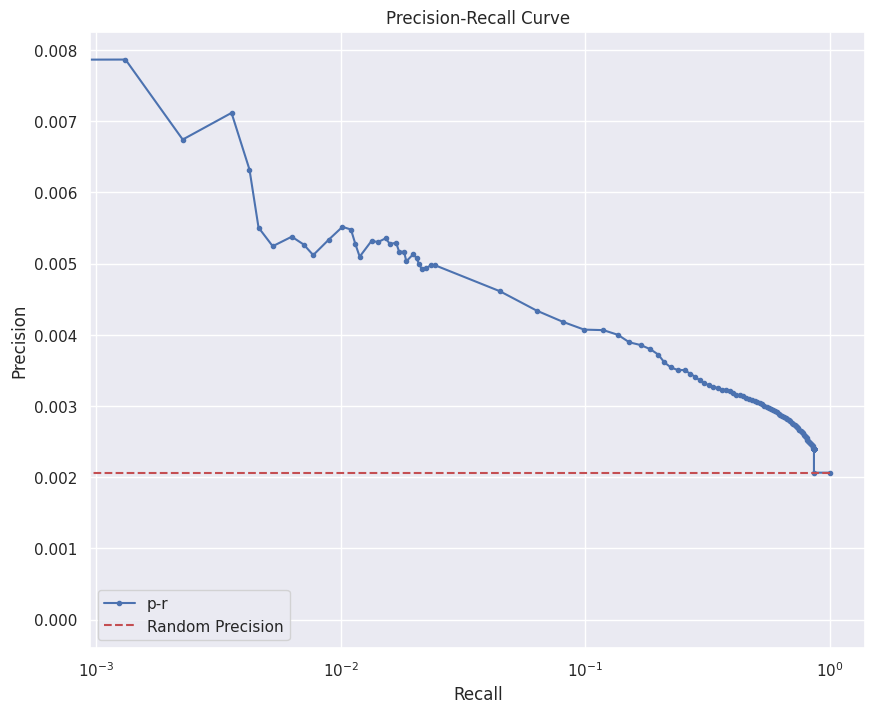

base enrichment


Top central genes: []


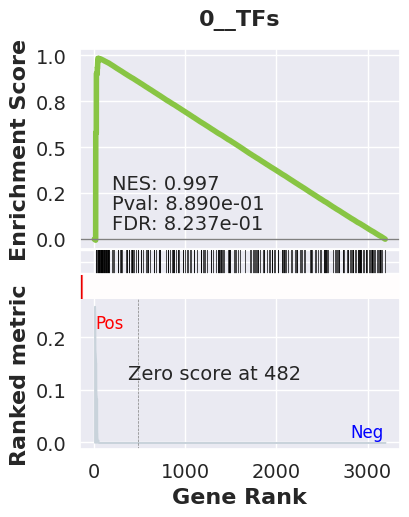

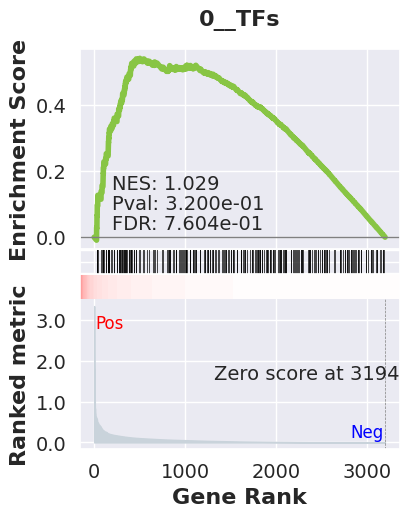

_________________________________________
TF specific enrichment


found some significant results for  13.157894736842104 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2272 genes
intersection pct: 0.7111111111111111
precision:  0.012966546636291633 
recall:  0.447576099210823 
random precision: 0.002062905836604834


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  8%|█████▍                                                               | 10/128 [00:00<00:01, 93.29it/s]

 19%|████████████▊                                                       | 24/128 [00:00<00:00, 117.87it/s]

 30%|████████████████████▏                                               | 38/128 [00:00<00:00, 126.24it/s]

 40%|███████████████████████████                                         | 51/128 [00:00<00:00, 119.94it/s]

 51%|██████████████████████████████████▌                                 | 65/128 [00:00<00:00, 124.60it/s]

 61%|█████████████████████████████████████████▍                          | 78/128 [00:00<00:00, 119.77it/s]

 72%|████████████████████████████████████████████████▉                   | 92/128 [00:00<00:00, 125.50it/s]

 82%|██████████████████████████████████████████████████████▉            | 105/128 [00:00<00:00, 125.14it/s]

 92%|█████████████████████████████████████████████████████████████▊     | 118/128 [00:00<00:00, 126.44it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 122.70it/s]

Average Precision (AP):  0.009521330088841158
Area Under Precision-Recall Curve (AUPRC):  0.008415469833906383
EPR: 10.552001786122725


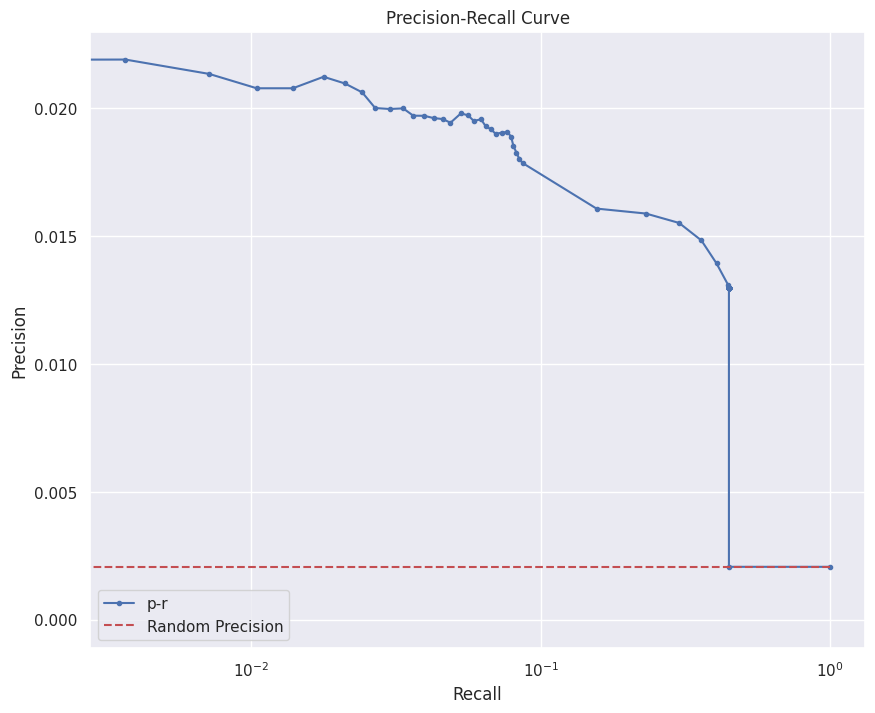

/tmp/ipykernel_2386617/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.


[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/26 [00:00<?, ?it/s]

base enrichment


Top central genes: []


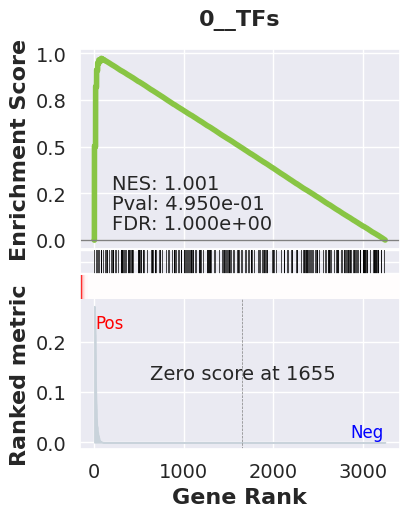

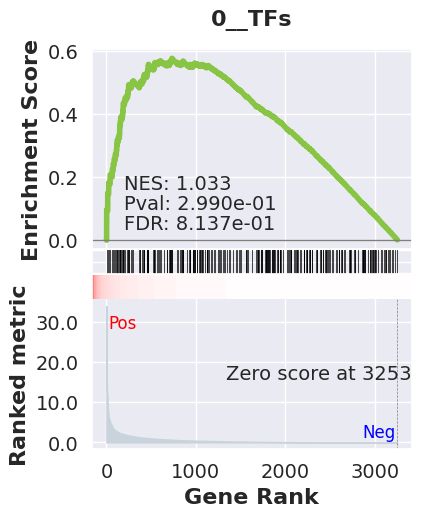

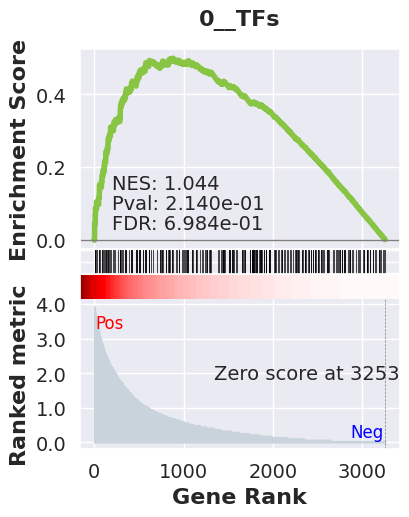

_________________________________________
TF specific enrichment


found some significant results for  13.88888888888889 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2219 genes
intersection pct: 0.6819299323909035
precision:  0.001554201146007484 
recall:  0.6924186568360314 
random precision: 0.0012676406036724395


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

  9%|██████▍                                                             | 12/128 [00:00<00:01, 114.41it/s]

 21%|██████████████▎                                                     | 27/128 [00:00<00:00, 131.83it/s]

 32%|█████████████████████▊                                              | 41/128 [00:00<00:00, 131.05it/s]

 43%|█████████████████████████████▏                                      | 55/128 [00:00<00:00, 131.48it/s]

 54%|████████████████████████████████████▋                               | 69/128 [00:00<00:00, 128.95it/s]

 66%|████████████████████████████████████████████▋                       | 84/128 [00:00<00:00, 133.17it/s]

 77%|████████████████████████████████████████████████████▌               | 99/128 [00:00<00:00, 137.28it/s]

 88%|███████████████████████████████████████████████████████████▏       | 113/128 [00:00<00:00, 132.27it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 135.22it/s]

100%|███████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 132.68it/s]

Average Precision (AP):  0.0018614606333902852
Area Under Precision-Recall Curve (AUPRC):  0.0018218958439401856
EPR: 2.7943402060418014


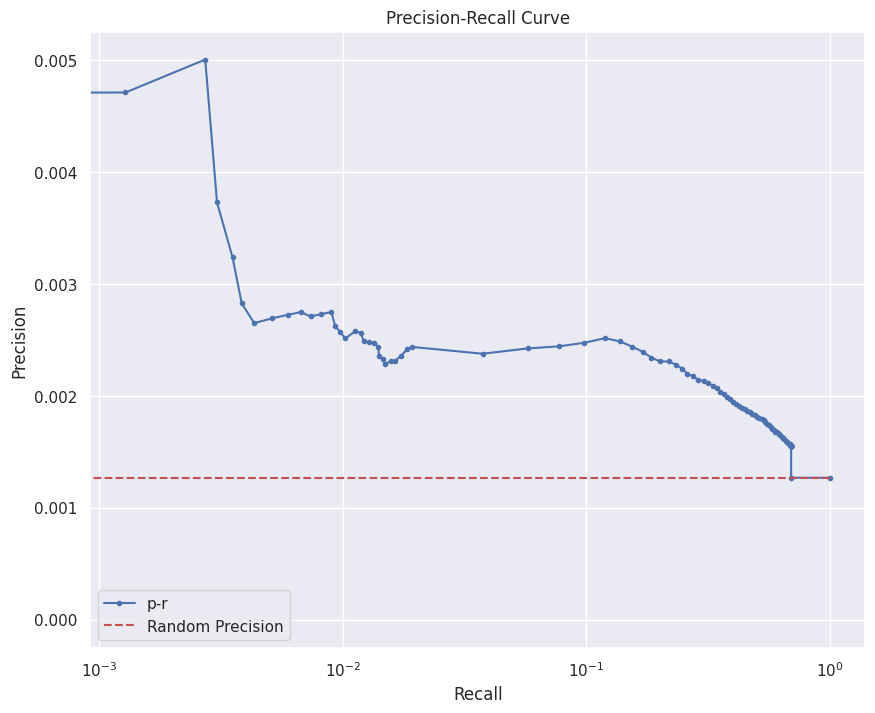

base enrichment


Top central genes: []


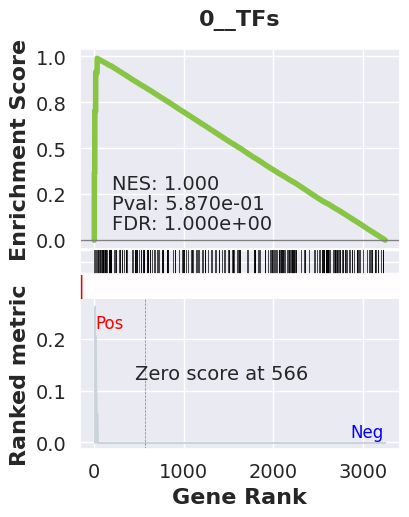

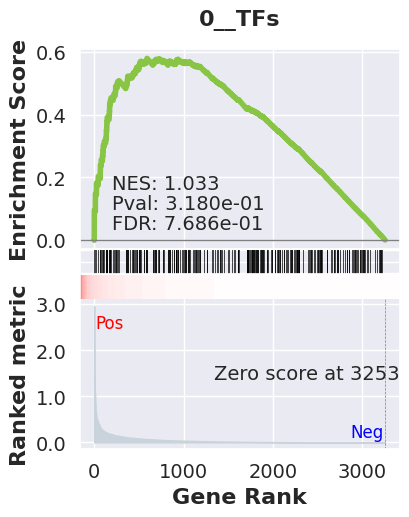

_________________________________________
TF specific enrichment


found some significant results for  8.333333333333334 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2219 genes
intersection pct: 0.6819299323909035
precision:  0.007446252545457822 
recall:  0.3311428113479724 
random precision: 0.0012676406036724395


  0%|                                                                              | 0/128 [00:00<?, ?it/s]

 11%|███████▍                                                            | 14/128 [00:00<00:00, 134.40it/s]

 22%|██████████████▉                                                     | 28/128 [00:00<00:00, 126.52it/s]

 33%|██████████████████████▎                                             | 42/128 [00:00<00:00, 129.35it/s]

 44%|█████████████████████████████▊                                      | 56/128 [00:00<00:00, 130.51it/s]

 55%|█████████████████████████████████████▋                              | 71/128 [00:00<00:00, 136.59it/s]

 66%|█████████████████████████████████████████████▏                      | 85/128 [00:00<00:00, 133.11it/s]

 77%|████████████████████████████████████████████████████▌               | 99/128 [00:00<00:00, 134.92it/s]

 89%|███████████████████████████████████████████████████████████▋       | 114/128 [00:00<00:00, 137.52it/s]

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:855: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|███████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 133.17it/s]

100%|███████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 133.06it/s]

Average Precision (AP):  0.004371965218088964
Area Under Precision-Recall Curve (AUPRC):  0.003802087987110403
EPR: 8.766378595697551


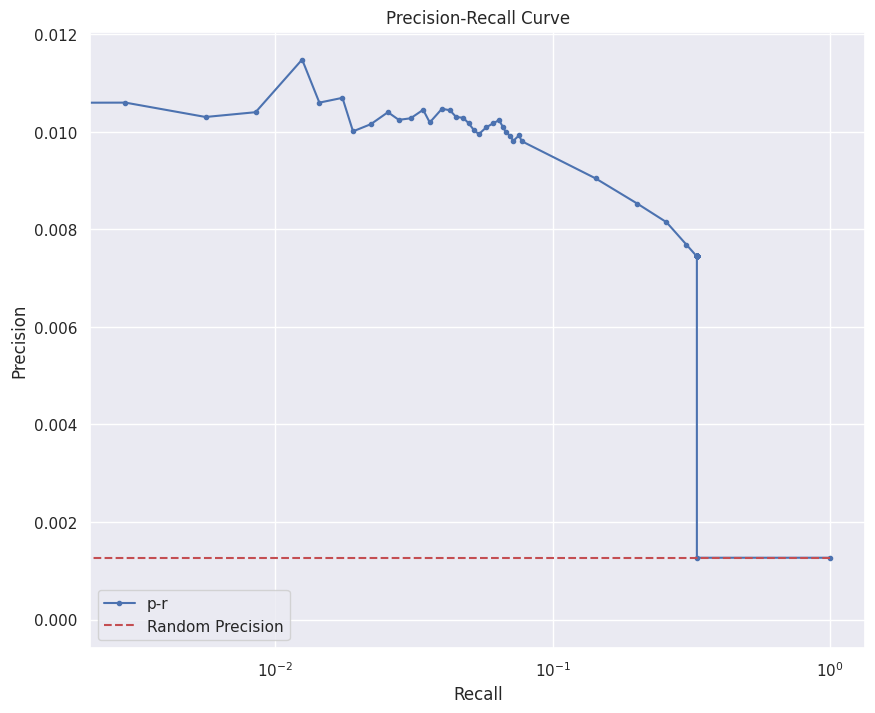

In [6]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
adata = adata[adata.X.sum(1) > 500]
metrics = {}
shapes = []
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype][:MAXCELLS, adata.var.index.isin(to_use)]
    grn = compute_geneformer_network(
        subadata)
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_'+celltype] = BenGRN(grn,
                                            do_auc=True, doplot=True).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF, :] = 0
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_TF_'+celltype] = BenGRN(grn,
                                         do_auc=True, doplot=True).scprint_benchmark()
    shapes.append(grn.shape[1])

In [7]:
metrics

{'geneformer_pigmented ciliary epithelial cell': {'enriched_terms_Central': ['celltype.gmt__Cone photoreceptor cells'],
  'TF_enr': False,
  'significant_enriched_TFtargets': 16.666666666666668,
  'precision': 0.0009929287901819144,
  'recall': 0.9912264995523724,
  'rand_precision': 0.0009757067366217241,
  'auprc': 0.0013638396248211383,
  'ap': 0.001369335100674096,
  'epr': 2.762088354837566},
 'geneformer_TF_pigmented ciliary epithelial cell': {'TF_enr': False,
  'significant_enriched_TFtargets': 6.666666666666667,
  'precision': 0.0044479937954613954,
  'recall': 0.41486123545210385,
  'rand_precision': 0.0009757067366217241,
  'auprc': 0.002872536490843387,
  'ap': 0.0033901442193911635,
  'epr': 6.1160790708647195},
 'geneformer_fibroblast': {'TF_enr': False,
  'enriched_terms_Targets': ['celltype.gmt__Myocytes'],
  'significant_enriched_TFtargets': 55.172413793103445,
  'precision': 0.0020541996158759184,
  'recall': 0.9606902279228569,
  'rand_precision': 0.001958167457378191

In [8]:
shapes

[3518, 3396, 2056, 4057, 3694, 2805, 2371, 3715, 3195, 3254]

In [9]:
True
True
True
True
True
True
True
True
False
False
False
False
True
True

True

In [10]:
import pandas as pd

In [11]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

name        EPR     AUPRC      RAND  \
0       pigmented ciliary epithelial cell   2.762088  0.001364  0.000976   
1       pigmented ciliary epithelial cell   6.116079  0.002873  0.000976   
2                              fibroblast   2.225429  0.002957  0.001958   
3                              fibroblast   8.636866  0.009552  0.001958   
4                            Schwann cell   2.560533  0.002259  0.001148   
5                            Schwann cell  12.211003  0.004663  0.001148   
6   non-pigmented ciliary epithelial cell   2.415614  0.001284  0.000877   
7   non-pigmented ciliary epithelial cell   7.473147  0.002493  0.000877   
8                     ciliary muscle cell   2.802498  0.001240  0.000820   
9                     ciliary muscle cell   7.164570  0.001832  0.000820   
10                             lymphocyte   4.818271  0.003266  0.001888   
11                             lymphocyte  12.851377  0.005280  0.001888   
12                             melanocyte   2.893449  0.002264  0.001271   
13                             melanocyte  21.467831  0.009351  0.001271   
14                             macrophage   1.811890  0.002855  0.002092   
15                             macrophage   9.068951  0.008142  0.002092   
16          blood vessel endothelial cell   2.566817  0.003131  0.002063   
17          blood vessel endothelial cell  10.552002  0.008415  0.002063   
18                               pericyte   2.794340  0.001822  0.001268   
19                               pericyte   8.766379  0.003802  0.001268   

      TF_targ  TF_enr  TF_only  
0   16.666667   False    False  
1    6.666667   False    False  
2   55.172414   False    False  
3   10.344828   False    False  
4    0.000000   False    False  
5    0.000000   False    False  
6   18.181818   False    False  
7    6.060606   False    False  
8    5.882353   False    False  
9   17.647059   False    False  
10  12.500000   False    False  
11   6.250000   False    False  
12  11.764706   False    False  
13   5.882353   False    False  
14   5.882353   False    False  
15   8.823529   False    False  
16  18.421053   False    False  
17  13.157895   False    False  
18  13.888889   False    False  
19   8.333333   False    False